In [315]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import spatial
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d
import networkx as nx
import pandas as pd

In [156]:
robot_positions = np.zeros((8,8,2))
kdtree_positions = np.zeros((64, 2))
for i in range(8):
    for j in range(8):
        if j%2==0:
            robot_positions[i,j] = (j*37.5, -21.65 + i*-43.301)
            kdtree_positions[i*8 + j, :] = robot_positions[i,j]
        else:
            robot_positions[i,j] = (j*37.5, i*-43.301)
            kdtree_positions[i*8 + j, :] = robot_positions[i,j]

(5.0, -362.25)

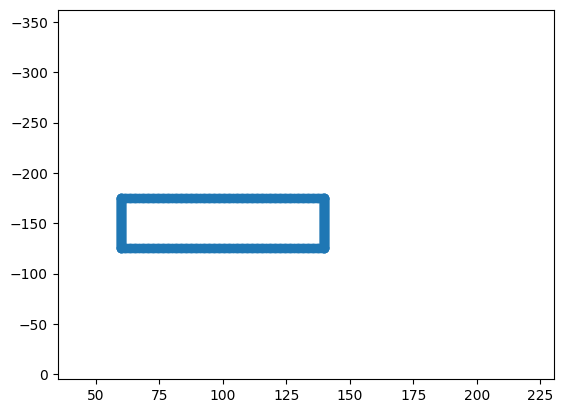

In [184]:
xy = np.array([100, -150])
plane_size = np.array([(35, 5),(230.25, -362.25)])

def boundary_points(x1, x2, y1, y2):
    corners = np.array([(x1, y1), (x1, y2), (x2, y2), (x2, y1)])
    left_right_edges = np.array([[(x1, y), (x2, y)] for y in range(y1, y2+1)])
    top_bottom_edges = np.array([[(x, y1), (x, y2)] for x in range(x1, x2+1)])    
    boundary_pts = np.concatenate((corners, left_right_edges[:,0], left_right_edges[:,1], top_bottom_edges[:,0],top_bottom_edges[:,1]))
    return boundary_pts

boundary_pts = boundary_points(x-40, x+40, y-25, y+25)
plt.scatter(boundary_pts[:,0],boundary_pts[:,1])
plt.xlim(35, 230.25)
plt.ylim(5, -362.25)

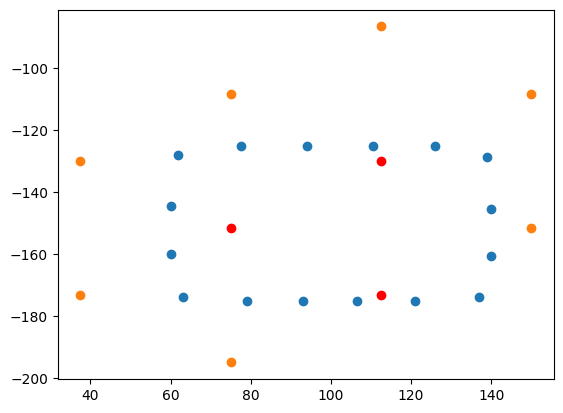

In [163]:
# def neighborhood_graph(dir_graph, robot_positions, idx, state_space)

kmeans = KMeans(n_clusters=16, random_state=0).fit(boundary_pts)
cluster_centers = kmeans.cluster_centers_
state_space = {i:tuple(cluster_centers[i]) for i in range(len(cluster_centers))}
state_space_inv = dict((v, k) for k, v in state_space.items())

hull = ConvexHull(cluster_centers)
A, b = hull.equations[:, :-1], hull.equations[:, -1:]
eps = np.finfo(np.float32).eps
idxs = set()
neg_idxs = set()
DG = nx.DiGraph()
pos = {}

for (i,j) in state_space_inv:
    n = state_space_inv[i,j]
    idx = spatial.KDTree(kdtree_positions).query((i,j))[1]
    if not (np.all(robot_positions[idx//8][idx%8] @ A.T + b.T < eps, axis=1)):
        DG.add_edge(n, (idx//8, idx%8), label=int(np.linalg.norm(robot_positions[idx//8][idx%8] - state_space[n])))
        pos[n] = state_space[n]
        pos[(idx//8, idx%8)] = robot_positions[idx//8][idx%8]
        idxs.add((idx//8, idx%8))
    else:
        kdt_pos_copy = kdtree_positions.copy()
        while np.all(robot_positions[idx//8][idx%8] @ A.T + b.T < eps, axis=1):
            DG.add_edge(n, (idx//8, idx%8), label=-int(np.linalg.norm(robot_positions[idx//8][idx%8] - state_space[n])))
            pos[n] = state_space[n]
            pos[(idx//8, idx%8)] = robot_positions[idx//8][idx%8]
            neg_idxs.add((idx//8, idx%8))

            kdt_pos_copy = np.delete(kdt_pos_copy, idx, axis=0)
            idx = spatial.KDTree(kdt_pos_copy).query((i,j))[1]
            
        x,y = kdt_pos_copy[idx]
        idx = np.where(np.isclose(kdtree_positions[:,0], x) & np.isclose(kdtree_positions[:,1], y) )[0][0]
        DG.add_edge(n, (idx//8, idx%8), label=int(np.linalg.norm(kdtree_positions[idx] - state_space[n])))
        pos[n] = state_space[n]
        pos[(idx//8, idx%8)] = robot_positions[idx//8][idx%8]
        idxs.add((idx//8, idx%8))
        

idxs = np.array(list(idxs))
neg_idxs = np.array(list(neg_idxs))
neighbors = robot_positions[idxs[:,0], idxs[:,1]]
neg_neighbors = robot_positions[neg_idxs[:,0], neg_idxs[:,1]]

plt.scatter(*cluster_centers.T)
plt.scatter(*neighbors.T)
plt.scatter(*neg_neighbors.T, color='red')

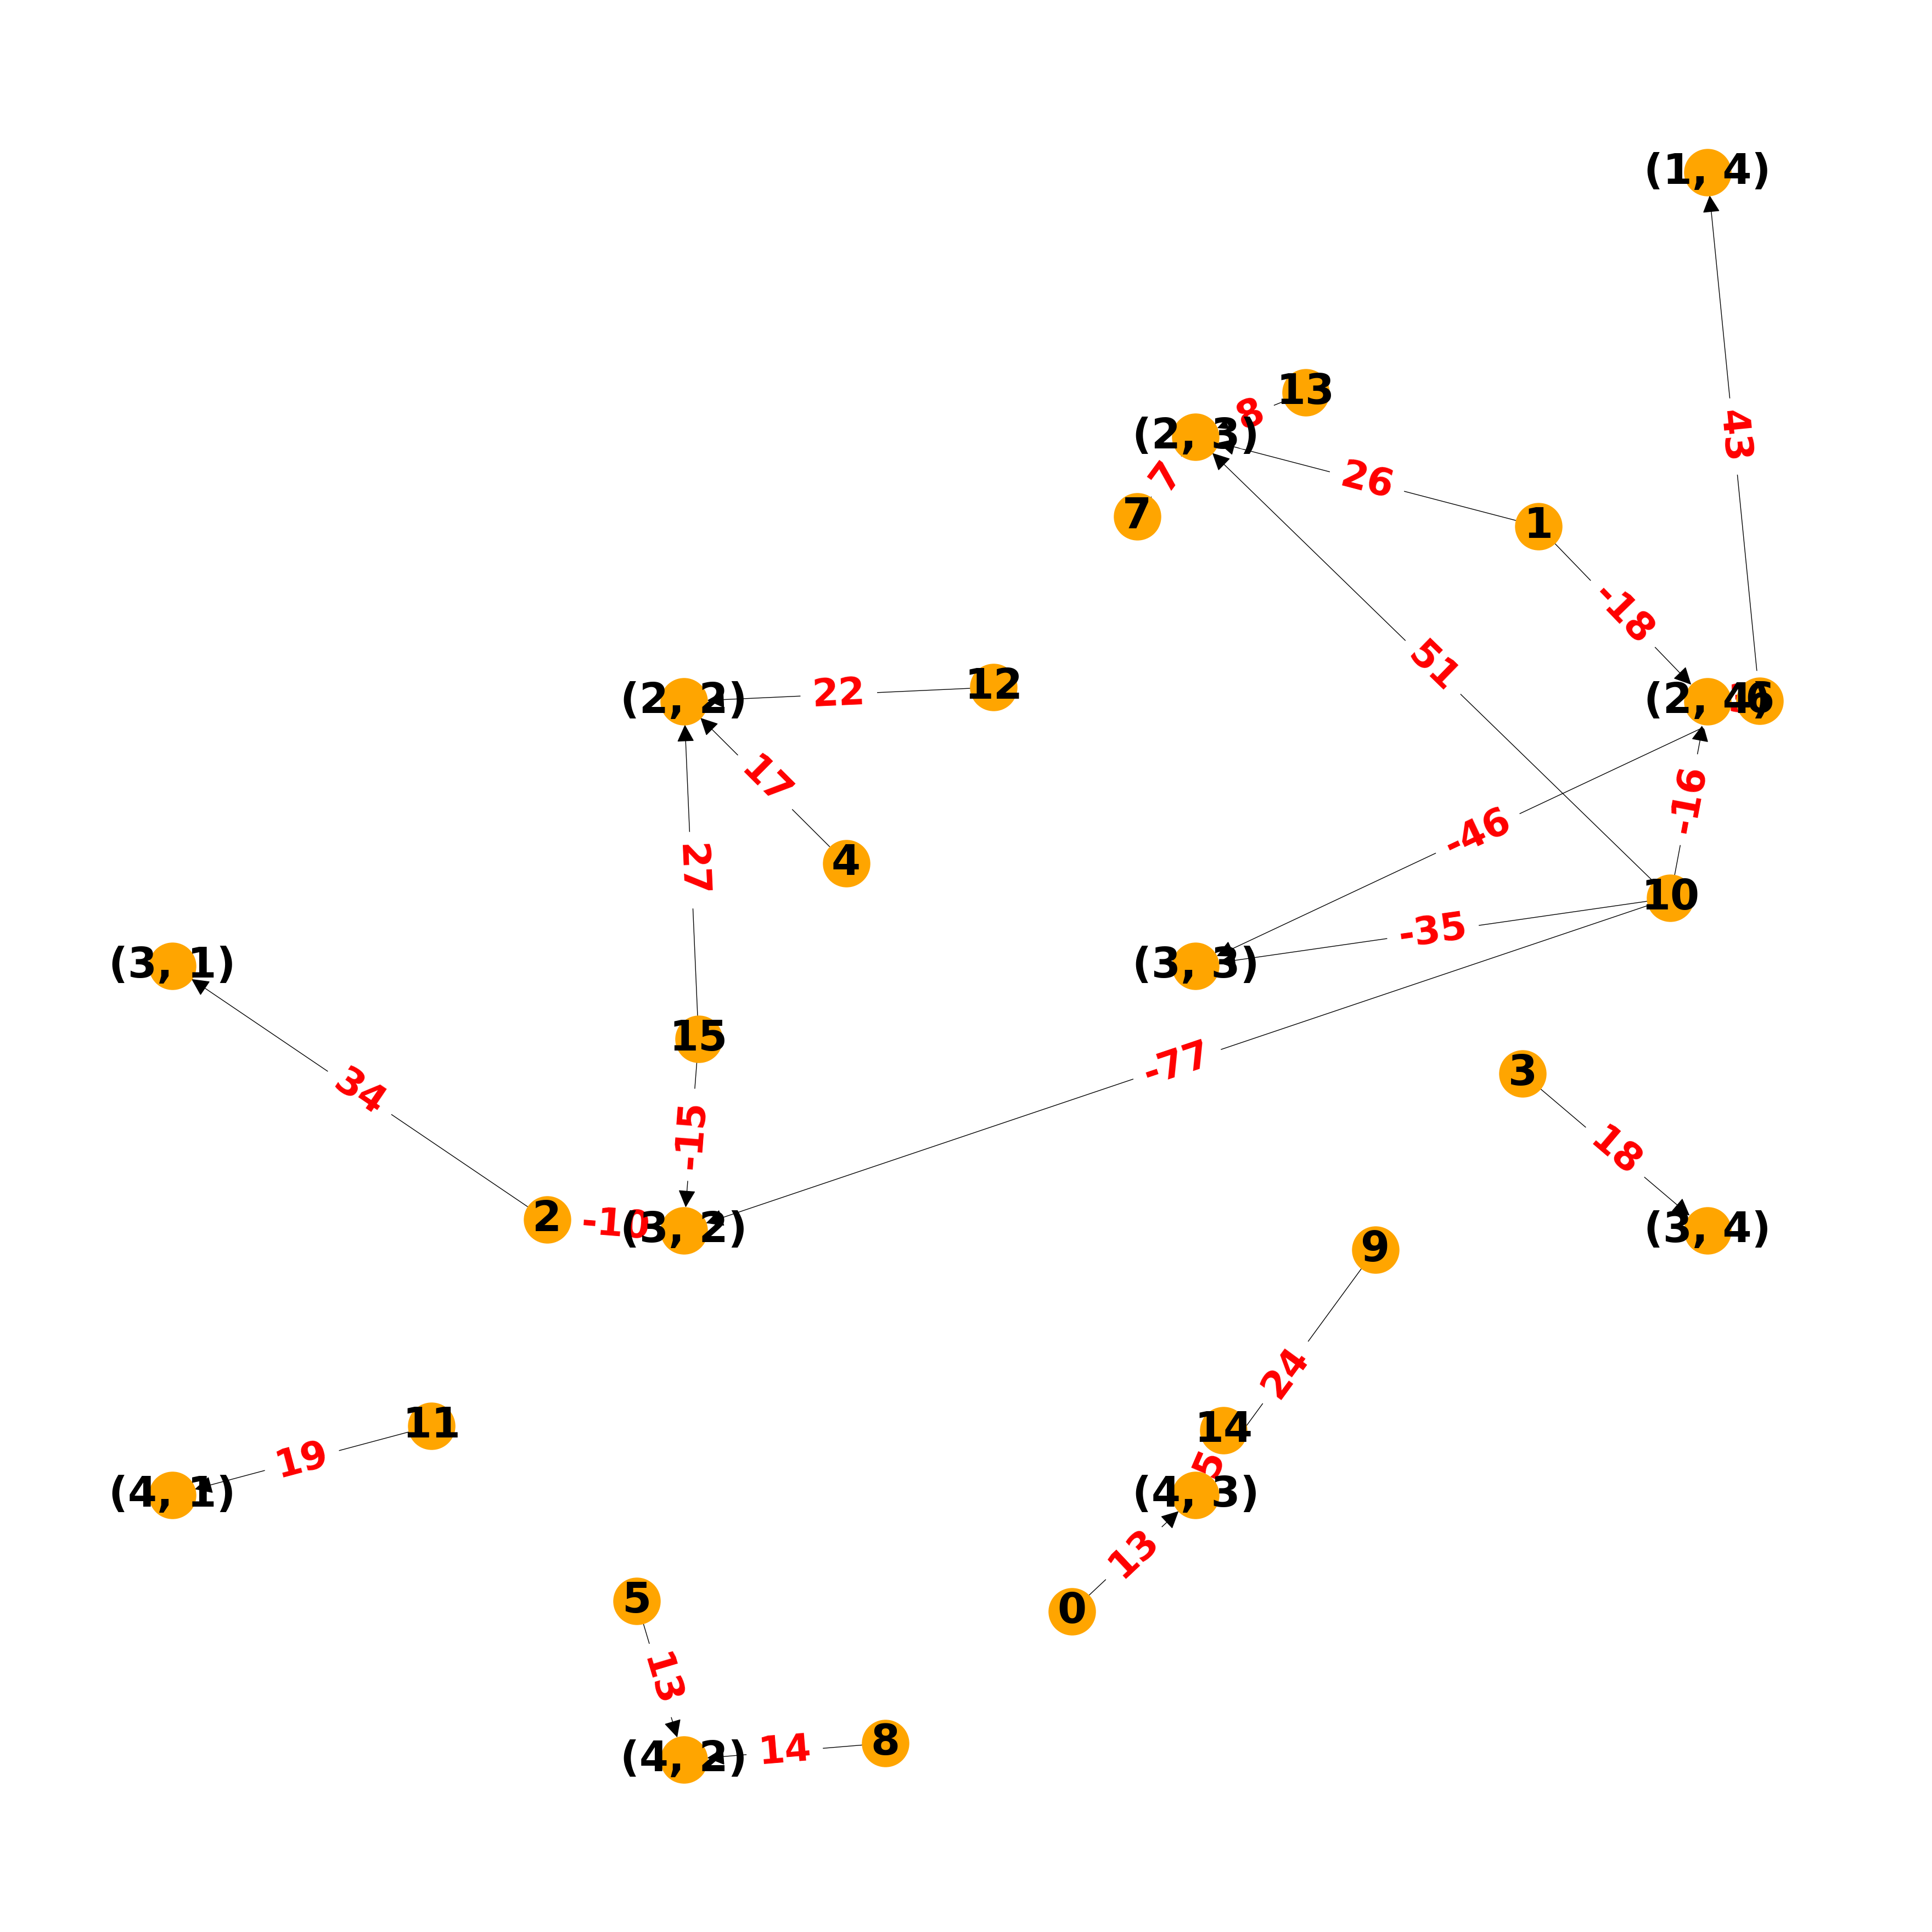

In [314]:
def draw_graph(graph, pos, scale = 1):
    plt.figure(figsize=(7*scale,7*scale))
    nx.draw(graph, pos, with_labels=True, node_color='orange', 
            node_size=750*scale,font_weight='bold', font_size=int(11*scale), 
            arrowsize=int(10*scale), edge_cmap=mpl.colormaps['jet'])
    edges = nx.draw_networkx_edge_labels(graph, pos, nx.get_edge_attributes(graph,'label'),
    font_color='red',font_weight='bold', font_size=int(10*scale))
    plt.show()
draw_graph(DG, pos, scale=5)

# Transform Boundary Points and Generate Graphs

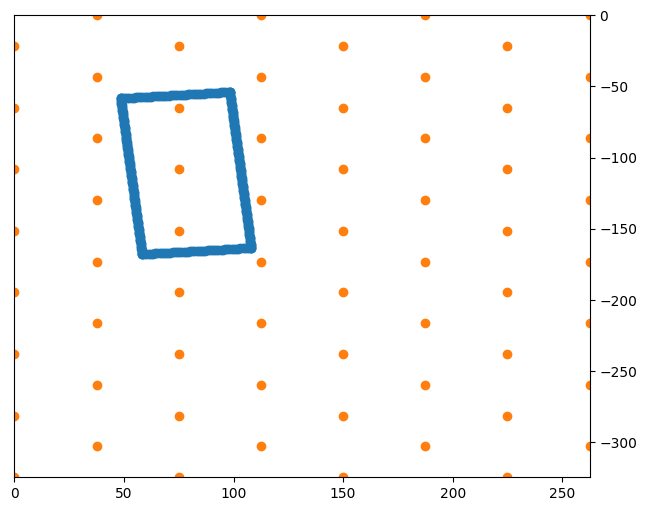

In [317]:
plane_size = np.array([(35, 5),(230.25, -362.25)])
bounds = np.array([np.min(kdtree_positions[:,0]), np.max(kdtree_positions[:,0]),np.min(kdtree_positions[:,1]),np.max(kdtree_positions[:,1])])
xy = np.array([(plane_size[0][0] + plane_size[1][0])//2, (plane_size[0][1] + plane_size[1][1])//2]).astype(np.int32)

def get_transformed_boundary():
    while True:
        theta = np.pi*np.random.uniform(0, 2)
        trans = np.array([np.random.uniform(-100, 100), np.random.uniform(-150, 150)])
        rot_matrix = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
        test = np.array([xy[0]-25, xy[0]+25, xy[1]-55, xy[1]+55])
        boundary_pts = boundary_points(*test)
        boundary_pts = (boundary_pts - xy)@rot_matrix + xy + trans
        block = np.array([np.min(boundary_pts[:,0]), np.max(boundary_pts[:,0]),np.min(boundary_pts[:,1]),np.max(boundary_pts[:,1])])
        if block[0]>bounds[0] and block[2]>bounds[2] and block[1]<bounds[1] and block[3]<bounds[3]:
            return boundary_pts
    

boundary_pts = get_transformed_boundary()
f = plt.figure(figsize=(6*1.237169,6)) 
ax = f.add_subplot(111)
ax.scatter(boundary_pts[:,0],boundary_pts[:,1])
ax.scatter(kdtree_positions[:,0],kdtree_positions[:,1])
ax.set_xlim(bounds[:2])
ax.set_ylim(bounds[2:])
ax.yaxis.tick_right()

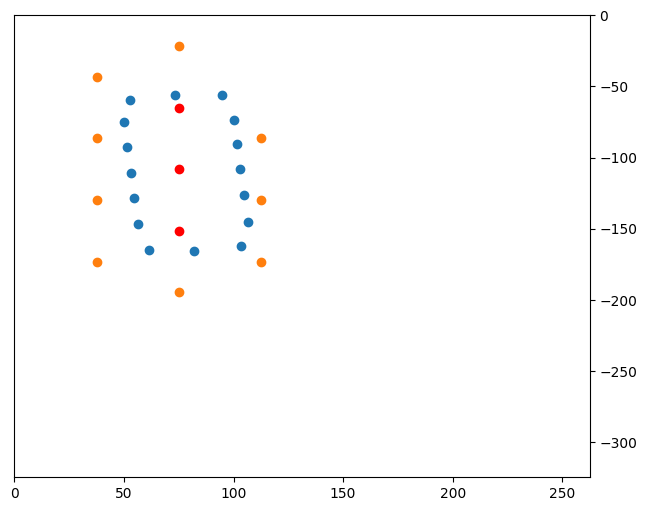

In [318]:
# def neighborhood_graph(dir_graph, robot_positions, idx, state_space)

kmeans = KMeans(n_clusters=16, random_state=0).fit(boundary_pts)
cluster_centers = kmeans.cluster_centers_
state_space = {i:tuple(cluster_centers[i]) for i in range(len(cluster_centers))}
state_space_inv = dict((v, k) for k, v in state_space.items())

hull = ConvexHull(cluster_centers)
A, b = hull.equations[:, :-1], hull.equations[:, -1:]
eps = np.finfo(np.float32).eps
idxs = set()
neg_idxs = set()
DG = nx.DiGraph()
pos = {}

for (i,j) in state_space_inv:
    n = state_space_inv[i,j]
    idx = spatial.KDTree(kdtree_positions).query((i,j))[1]
    if not (np.all(robot_positions[idx//8][idx%8] @ A.T + b.T < eps, axis=1)):
        DG.add_edge(n, (idx//8, idx%8), label=int(np.linalg.norm(robot_positions[idx//8][idx%8] - state_space[n])))
        pos[n] = state_space[n]
        pos[(idx//8, idx%8)] = robot_positions[idx//8][idx%8]
        idxs.add((idx//8, idx%8))
    else:
        kdt_pos_copy = kdtree_positions.copy()
        while np.all(robot_positions[idx//8][idx%8] @ A.T + b.T < eps, axis=1):
            DG.add_edge(n, (idx//8, idx%8), label=-int(np.linalg.norm(robot_positions[idx//8][idx%8] - state_space[n])))
            pos[n] = state_space[n]
            pos[(idx//8, idx%8)] = robot_positions[idx//8][idx%8]
            neg_idxs.add((idx//8, idx%8))

            kdt_pos_copy = np.delete(kdt_pos_copy, idx, axis=0)
            idx = spatial.KDTree(kdt_pos_copy).query((i,j))[1]
            
        x,y = kdt_pos_copy[idx]
        idx = np.where(np.isclose(kdtree_positions[:,0], x) & np.isclose(kdtree_positions[:,1], y) )[0][0]
        DG.add_edge(n, (idx//8, idx%8), label=int(np.linalg.norm(kdtree_positions[idx] - state_space[n])))
        pos[n] = state_space[n]
        pos[(idx//8, idx%8)] = robot_positions[idx//8][idx%8]
        idxs.add((idx//8, idx%8))
        

idxs = np.array(list(idxs))
neg_idxs = np.array(list(neg_idxs))
neighbors = robot_positions[idxs[:,0], idxs[:,1]]
neg_neighbors = robot_positions[neg_idxs[:,0], neg_idxs[:,1]]


f = plt.figure(figsize=(6*1.237169,6)) 
ax = f.add_subplot(111)
ax.scatter(*cluster_centers.T)
ax.scatter(*neighbors.T)
ax.scatter(*neg_neighbors.T, color='red')
ax.set_xlim(bounds[:2])
ax.set_ylim(bounds[2:])
ax.yaxis.tick_right()


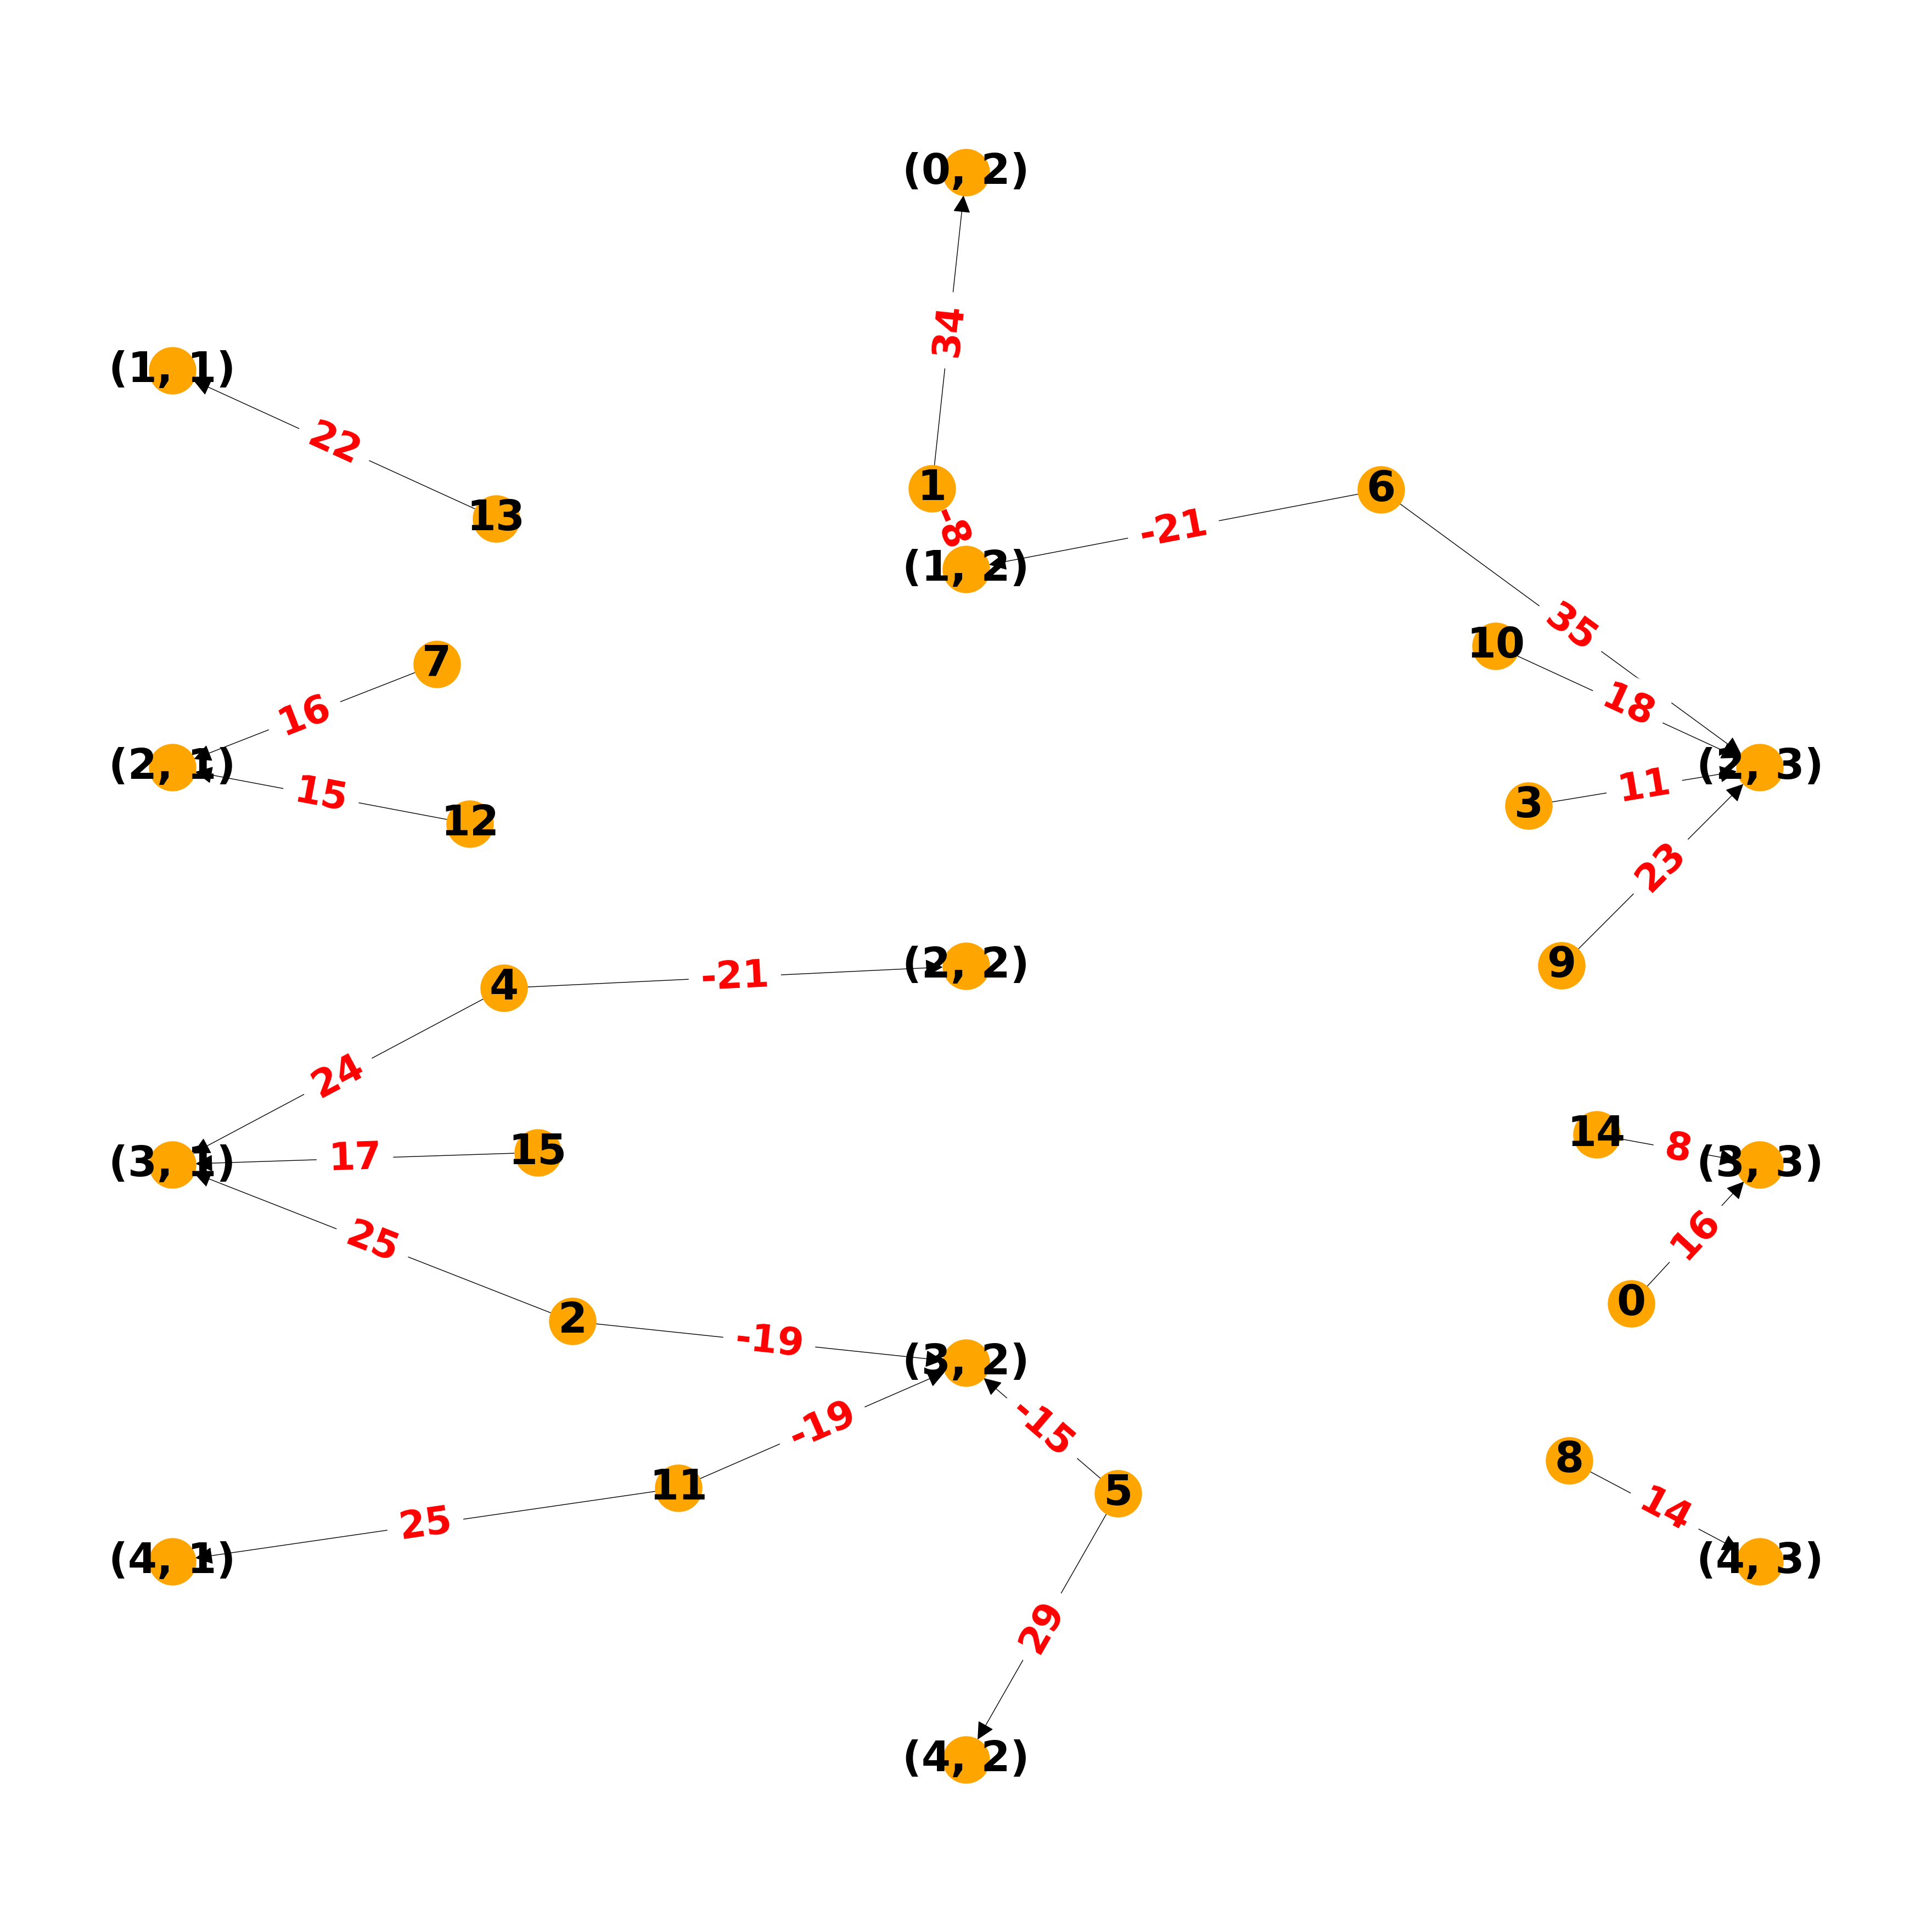

In [319]:
draw_graph(DG, pos, scale=5)